In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import log_parse

Define funtions to parse and plot the results.

In [15]:
def timestamp_plot(fig, tasks_time):
    """
    Plot a timeline of tasks
    """
    start = tasks_time[0][1]

    for i in range(len(tasks_time)):
        if tasks_time[i][0] == "read":
            fig.axvspan(xmin=tasks_time[i][1] - start, xmax=tasks_time[i][2] - start, color="g", alpha=0.2,
                        label="read" if i == 0 else "")
        else:
            fig.axvspan(xmin=tasks_time[i - 1][2] - start, xmax=tasks_time[i][1] - start, color="k", alpha=0.2,
                        label="computation" if i == 1 else "")
            fig.axvspan(xmin=tasks_time[i][1] - start, xmax=tasks_time[i][2] - start, color="b", alpha=0.2,
                        label="write" if i == 1 else "")


def mem_plot(fig, atoplog, time_stamp, input_size, readonly=False):
    """
    Plot memory properties: capacity, cache used, free memory, available memory, dirty data
    """
    dirty_data = np.array(atoplog["total"])
    intervals = len(dirty_data)
    time = np.arange(0, intervals)

    fig.minorticks_on()
    fig.set_title("memory profiling (input size = %s MB)" % input_size)

    timestamp_plot(fig, time_stamp)

    # app_cache = list(np.array(app_mem) + np.array(cache_used))

    fig.plot(time, atoplog["total"], color='k', linewidth=1, linestyle=":", label="total mem")
    # ax1.plot(time, free_mem, color='g', linewidth=1.5, linestyle="-.", label="free memory")
    fig.plot(time, atoplog["used_mem"], color='g', linewidth=1.5, label="used mem")
    # ax1.plot(time, app_mem, color='c', linewidth=1.5, label="app memory")
    fig.plot(time, atoplog["cache"], color='m', linewidth=1.5, label="cache used")
    # ax1.plot(time, app_cache, color='c', linewidth=1.5, label="cache + app")
    fig.plot(time, atoplog["dirty_data"], color='r', linewidth=1.5, label="dirty data")
    fig.plot(time, atoplog["avai_mem"], color='b', linewidth=1, linestyle="-.", label="available mem")
    fig.plot(time, atoplog["dirty_ratio"], color='k', linewidth=1, linestyle="-.", label="dirty_ratio")
    fig.plot(time, atoplog["dirty_bg_ratio"], color='r', linewidth=1, linestyle="-.", label="dirty_bg_ratio")

    fig.legend(fontsize='small', loc='upper right')


def collectl_plot(fig, collectl_log_file, time_stamp, readonly=False):
    """
    Plot disk throughput
    """
    skip_rows = 16
    disk_name = "sda"
    start_idx = -1
    read = []
    write = []

    with open(collectl_log_file) as csv_file:

        csv_reader = csv.reader(csv_file, delimiter=',')
        for i in range(skip_rows):
            next(csv_reader)

        for line in csv_reader:
            if start_idx < 0:
                start_idx = line.index(disk_name)

            read.append(float(line[start_idx + 3]) / 1000)
            write.append(float(line[start_idx + 7]) / 1000)

    time = np.arange(0, len(read))

    fig.minorticks_on()
    fig.set_title("disk throughput (MB)")

    timestamp_plot(fig, time_stamp)     

    fig.plot(time, read, color='g', linewidth=1.5, label="read")
    fig.plot(time, write, color='r', linewidth=1.5, label="write")
    fig.legend(fontsize='small', loc='best')
    
    
def plot(input_size_mb, x_min=0, x_max=1000):
    """
    Plot all props of a real pipeline
    """
    
    atop_log_file="real/%dgb/atop_mem.log" % int(input_size_mb/1000)
    timestamps_file="real/%dgb/timestamps.csv" % int(input_size_mb/1000)
    collectl_log_file="real/%dgb/collectl.dsk" % int(input_size_mb/1000)
    
    atop_log = log_parse.read_atop_log(atop_log_file, dirty_ratio=0.4, dirty_bg_ratio=0.1)
    timestamps = log_parse.read_timelog(timestamps_file, skip_header=False)
    # timestamps = None

    figure = plt.figure()
    plt.tight_layout()
    ax1 = figure.add_subplot(2, 1, 1)
    ax2 = figure.add_subplot(2, 1, 2, sharex=ax1)

    ax1.set_ylim(top=280000, bottom=-10000)
    ax1.set_xlim(left=x_min, right=x_max)
    mem_plot(ax1, atop_log, timestamps, input_size_mb)

    collectl_plot(ax2, collectl_log_file, timestamps)

    plt.show()

Plot the results of the real pipeline with input file size

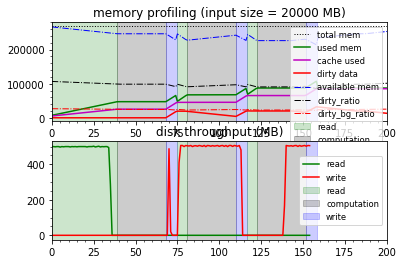

In [16]:
plot(input_size_mb=20000, x_min=0, x_max=200)

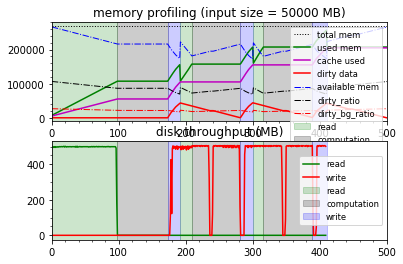

In [17]:
plot(input_size_mb=50000, x_min=0, x_max=500)

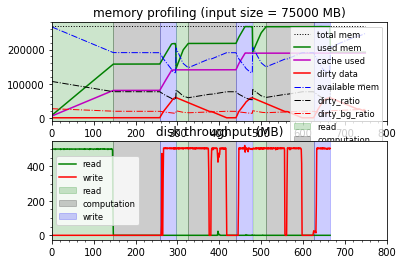

In [18]:
plot(input_size_mb=75000, x_min=0, x_max=800)

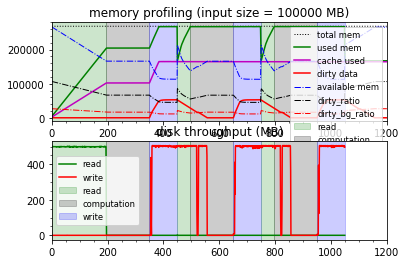

In [19]:
plot(input_size_mb=100000, x_min=0, x_max=1200)